In [1]:
import os
# 设置代理 使服务器走本机代理端口
%env HTTP_PROXY=http://10.156.216.53:10809
%env HTTPS_PROXY=http://10.156.216.53:10809
os.getenv("HTTP_PROXY")



env: HTTP_PROXY=http://10.156.216.53:10809
env: HTTPS_PROXY=http://10.156.216.53:10809


'http://10.156.216.53:10809'

In [2]:

import torch
from diffusers import DDIMScheduler, DDIMInverseScheduler, StableDiffusionDiffEditPipeline
from diffusers.utils import load_image, make_image_grid
from PIL import Image

# 下载hugging face 模型，时间较长，且可能因网络问题出现错误
pipeline = StableDiffusionDiffEditPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1",
    torch_dtype=torch.float16,
    safety_checker=None,
    use_safetensors=True,
)
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.inverse_scheduler = DDIMInverseScheduler.from_config(pipeline.scheduler.config)
pipeline.enable_model_cpu_offload()
pipeline.enable_vae_slicing()


Couldn't connect to the Hub: (MaxRetryError("HTTPSConnectionPool(host='hf-mirror.com', port=443): Max retries exceeded with url: /api/models/stabilityai/stable-diffusion-2-1 (Caused by ProxyError('Unable to connect to proxy', ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7f7e7b28c9a0>, 'Connection to 10.156.216.53 timed out. (connect timeout=None)')))"), '(Request ID: 6eba26b3-6c79-4d97-86df-b259a28be80c)').
Will try to load from local cache.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to DDIMInverseScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


## 修改单个图片进行测试

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

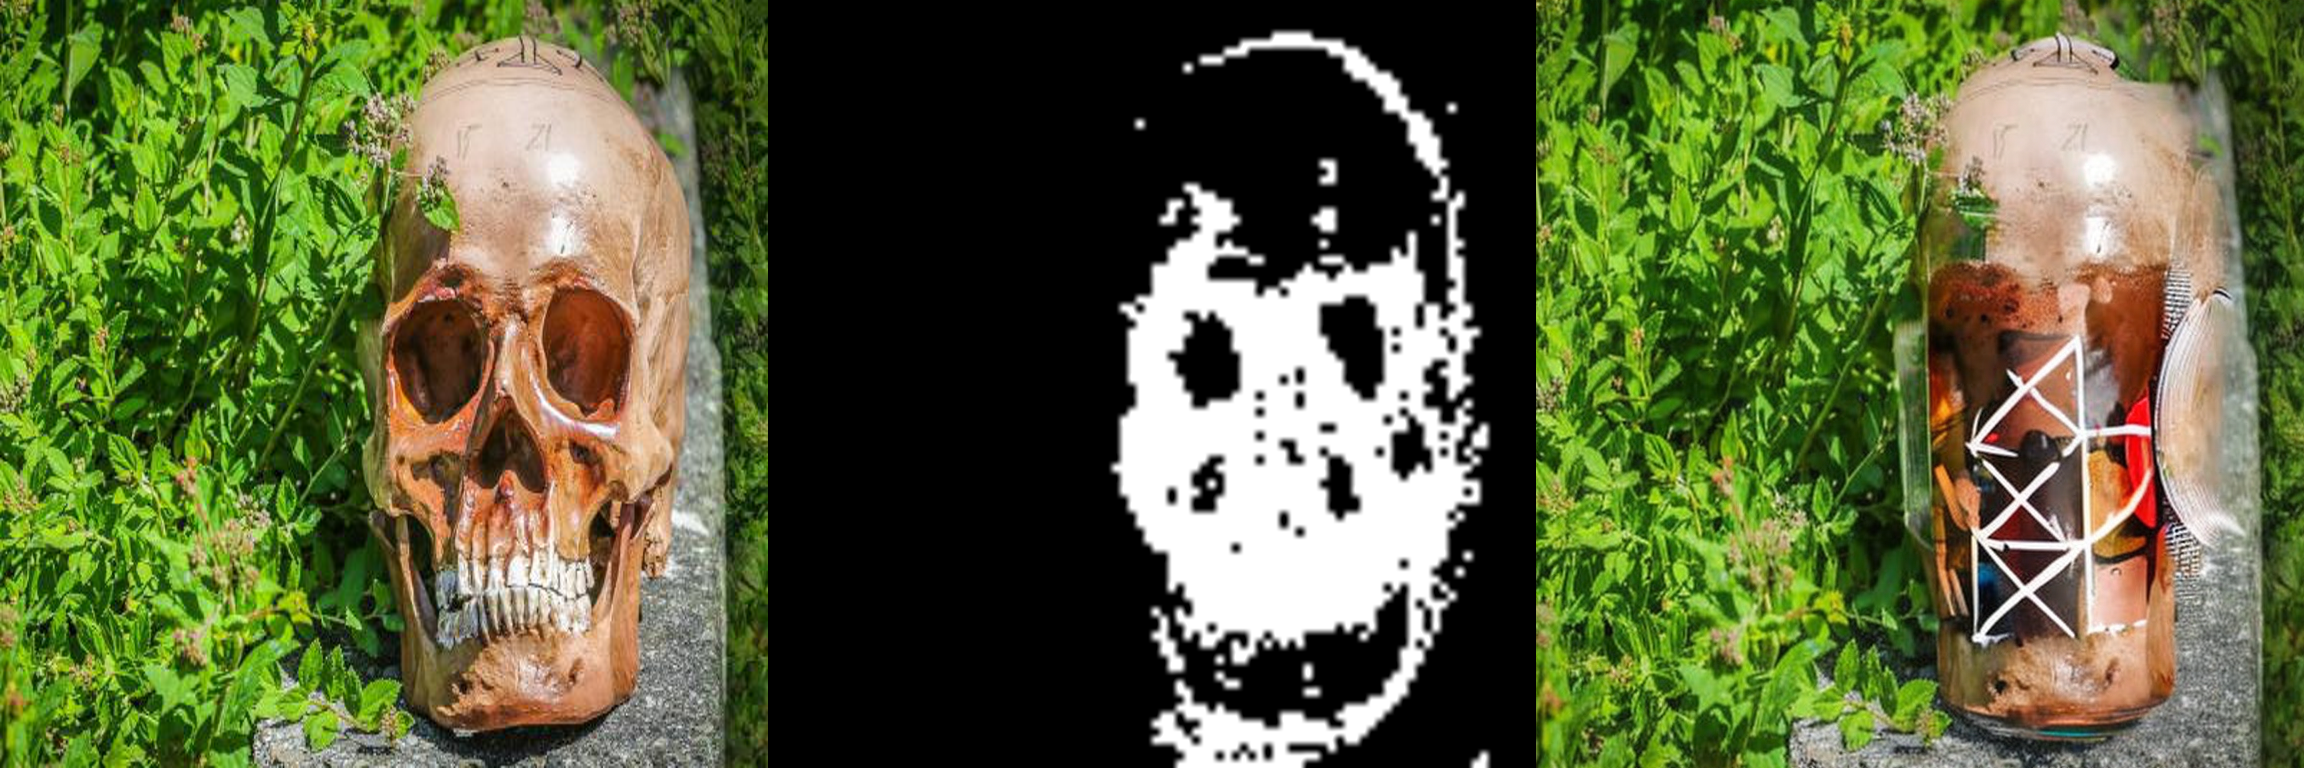

In [3]:

img_url =  "../data/skull/Skull_Infringement/postive/1.jpg"

# img_url = "https://github.com/Xiang-cd/DiffEdit-stable-diffusion/raw/main/assets/origin.png"
raw_image = load_image(img_url).resize((768, 768))
raw_image
source_prompt = "skull"
target_prompt = "random products"
mask_image = pipeline.generate_mask(
    image=raw_image,
    source_prompt=source_prompt,
    target_prompt=target_prompt,
)
Image.fromarray((mask_image.squeeze()*255).astype("uint8"), "L").resize((768, 768))
inv_latents = pipeline.invert(prompt=source_prompt, image=raw_image).latents
output_image = pipeline(
    prompt=target_prompt,
    mask_image=mask_image,
    image_latents=inv_latents,
    negative_prompt=source_prompt,
).images[0]
mask_image = Image.fromarray((mask_image.squeeze()*255).astype("uint8"), "L").resize((768, 768))
make_image_grid([raw_image, mask_image, output_image], rows=1, cols=3)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

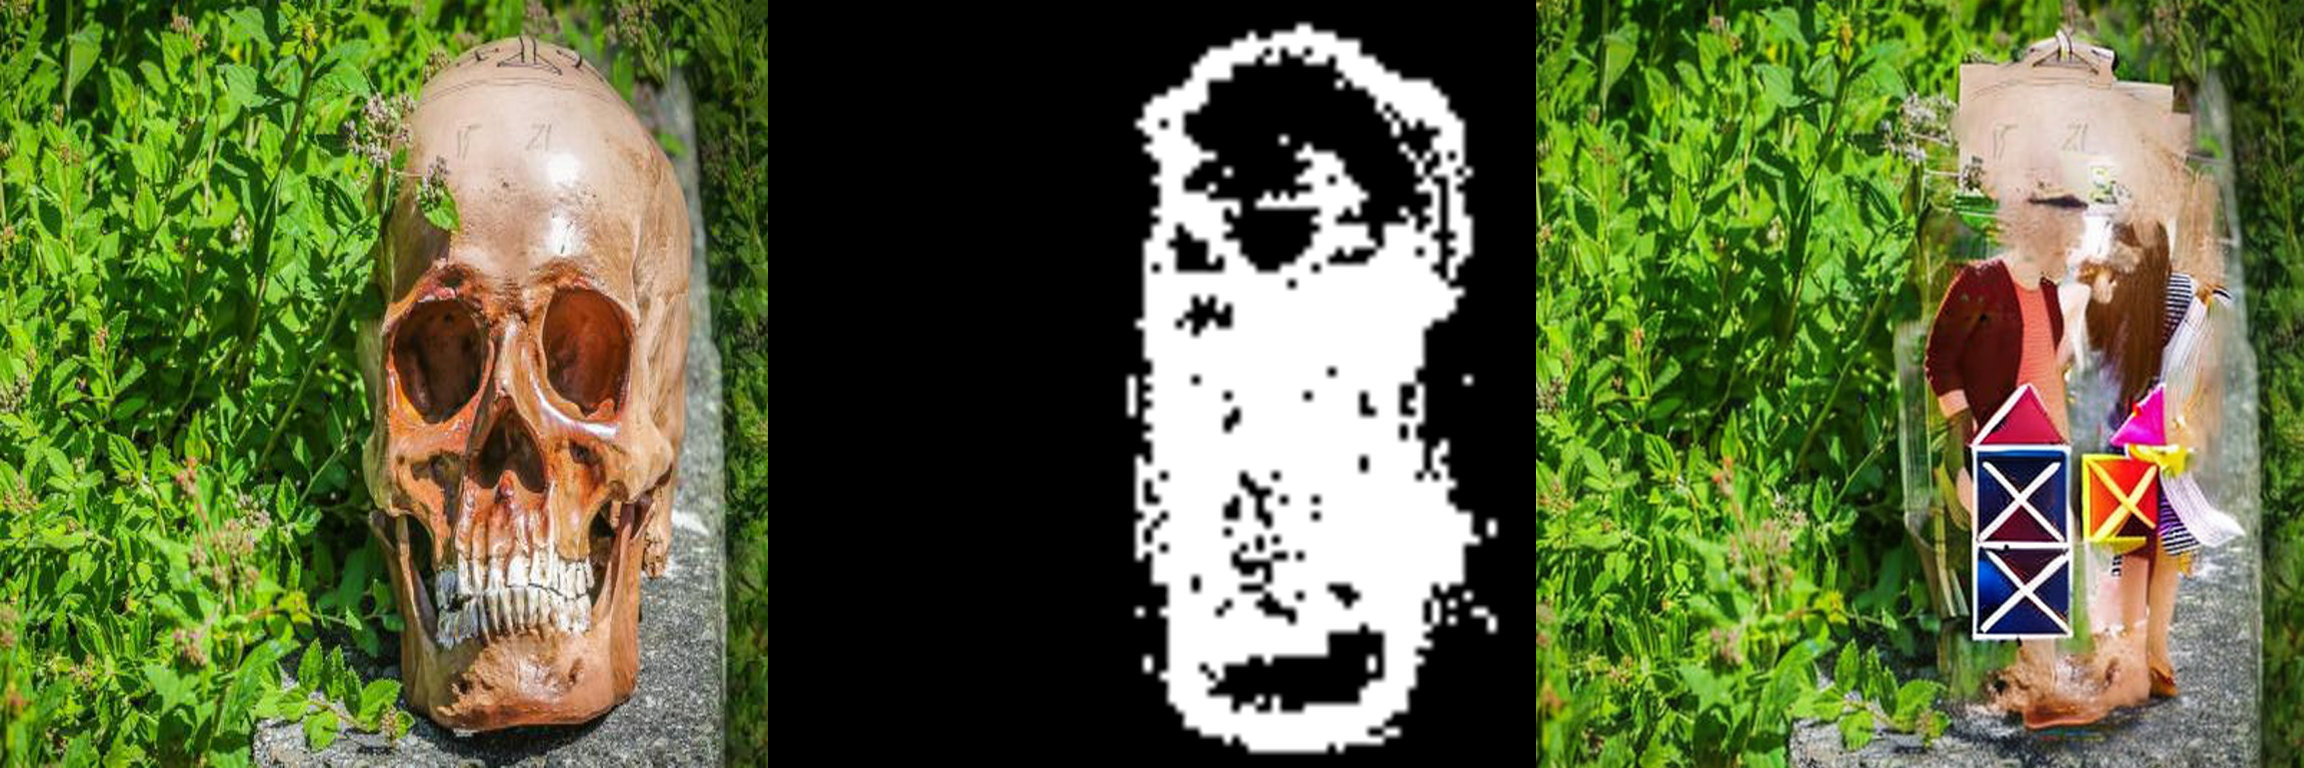

In [4]:
# 使用修改后的图像作为新的 raw_image
raw_image2 = output_image.resize((768, 768))

# 生成新的 mask 图像
mask_image = pipeline.generate_mask(
    image=raw_image2,
    source_prompt=source_prompt,
    target_prompt=target_prompt,
)

# 反向嵌入
inv_latents = pipeline.invert(prompt=source_prompt, image=raw_image2).latents

# 生成新的输出图像
output_image = pipeline(
    prompt=target_prompt,
    mask_image=mask_image,
    image_latents=inv_latents,
    negative_prompt=source_prompt,
).images[0]

# 处理 mask_image
mask_image = Image.fromarray((mask_image.squeeze()*255).astype("uint8"), "L").resize((768, 768))

# 显示结果图像
make_image_grid([raw_image, mask_image, output_image], rows=1, cols=3)

## 批量处理训练数据

In [ ]:

from tqdm import tqdm
skull_image_url = '../data/skull/Skull_Infringement/postive'
output_image_url = '../data/skull/diffedit'
skull_images = os.listdir(skull_image_url)
skull_images = sorted(skull_images, key=lambda x: int(os.path.splitext(x)[0]))
# print(skull_images)
# input()
source_prompt = "skull"
target_prompt = "random products"
for skull_image in tqdm(skull_images, desc="Processing images"):
    raw_image = load_image(os.path.join(skull_image_url, skull_image)).resize((768, 768))

    mask_image = pipeline.generate_mask(
        image=raw_image,
        source_prompt=source_prompt,
        target_prompt=target_prompt,
    )
    Image.fromarray((mask_image.squeeze()*255).astype("uint8"), "L").resize((768, 768))

    inv_latents = pipeline.invert(prompt=source_prompt, image=raw_image).latents

    output_image = pipeline(
        prompt=target_prompt,
        mask_image=mask_image,
        image_latents=inv_latents,
        negative_prompt=source_prompt,
    ).images[0]

    # 使用修改后的图像作为新的 raw_image
    raw_image2 = output_image.resize((768, 768))

    # 生成新的 mask 图像
    mask_image = pipeline.generate_mask(
        image=raw_image2,
        source_prompt=source_prompt,
        target_prompt=target_prompt,
    )
    # 反向嵌入
    inv_latents = pipeline.invert(prompt=source_prompt, image=raw_image2).latents
    # 生成新的输出图像
    output_image = pipeline(
        prompt=target_prompt,
        mask_image=mask_image,
        image_latents=inv_latents,
        negative_prompt=source_prompt,
    ).images[0]

    output_image.save(os.path.join(output_image_url, f"{skull_image}"))
    # mask_image = Image.fromarray((mask_image.squeeze()*255).astype("uint8"), "L").resize((768, 768))
    # make_image_grid([raw_image, mask_image, output_image], rows=1, cols=3)
    